In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import time
import seaborn as sns

In [2]:
# Load data

with open("data/2022-08-02-01.json", "r") as file:
    data_text = file.read()
    data_dict = json.loads(data_text)
    data = np.array(data_dict["trace_array"])

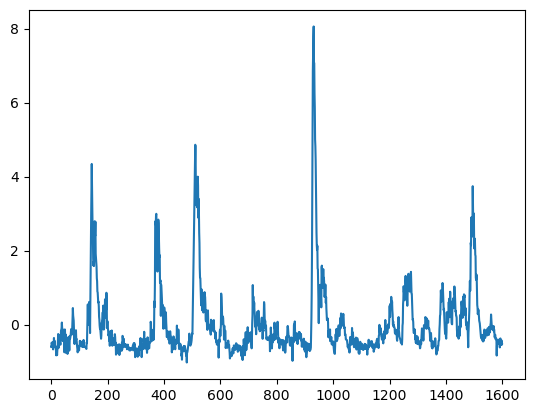

In [3]:
plt.plot(data[15])

In [4]:
152 * 20

3040

In [5]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.first_layer = nn.Linear(3040, 100)
        self.first_act = nn.LeakyReLU()
        self.second_layer = nn.Linear(100, 100)
        self.second_act = nn.LeakyReLU()

        self.process = nn.Sequential(self.first_layer,
                                     self.first_act,
                                     self.second_layer,
                                     self.second_act,)
        
        self.final_layer = nn.Linear(100, 152)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 3040))
        x = self.process(x)
        x = self.final_layer(x)
        return x

In [6]:
test_model = SimpleNetwork()

In [7]:
total_params = 0

for param in test_model.parameters():
    total_params += param.detach().numpy().size

print(total_params)

329552


In [8]:
# Window Sample

simple_x = []
simple_y = []

for i in range(1580):
    window = data[:, i:i+20]
    simple_x.append(window)
    simple_y.append(data[:, i+20])

simple_x = np.array(simple_x)
simple_y = np.array(simple_y)

def val_test(model):
    window = simple_x[0]
    window = window.reshape(1, 152, 20)
    
    line = []
    
    for i in range(1500):
        input = torch.from_numpy(window).float()
        out = model(input).detach().numpy().reshape(1, 152, 1)
        line.append(out)
        window = np.concatenate((window[:, :, 1:], out), axis=2) 
    
    line = np.array(line).reshape(1500, 152)
    ext_line = np.concatenate((simple_x[0].T, line), axis = 0).T

    loss = (ext_line[:,:1500] - data[:,:1500]) ** 2
    return np.sum(loss)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(simple_x, simple_y, test_size=0.2, random_state=5, shuffle=True)

In [10]:
x_train.shape, y_train.shape

((1264, 152, 20), (1264, 152))

In [11]:
def train(model, criterion, optimizer, points, labels, test_x, test_y, epoches=5, do_print=True):

    train_loss_per_epoch = []
    test_loss_per_epoch = []
    val_loss_per_epoch = []
    
    total_start_time = time.time()
    loss = -1
    for i in range(1,epoches+1):
        start_time = time.time()
        optimizer.zero_grad()
        y = model(points)
        loss = criterion(y, labels)
        loss.backward()
        optimizer.step()
        end_time = time.time()

        test_out = model(test_x)
        test_loss = criterion(test_out, test_y)

        train_loss_per_epoch.append(loss.item())
        test_loss_per_epoch.append(test_loss.item())
        
        if(i % 50 == 0 and do_print):
            val_loss = val_test(model)
            val_loss_per_epoch.append([i, val_loss])
            print(f"{i}: Loss {loss.item()}, Test Loss {test_loss.item()}, Val Loss {val_loss}")
            torch.save({
                'epoch': i,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimiser.state_dict(),
                }, f"checkpoints/micro_nn/model_epoch_{i}.pt")
            
    total_end_time = time.time()
    total_time_taken = total_end_time - total_start_time
    if(do_print):
        print(f"Total Time {total_time_taken}")
        
    final_loss = loss.item()
    
    return (total_time_taken, final_loss, train_loss_per_epoch, test_loss_per_epoch, val_loss_per_epoch)

In [17]:
# Training Setup

torch.manual_seed(4687)
model = SimpleNetwork()

optimiser = optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss()

x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

test_tensor = torch.from_numpy(x_test).float()
test_y_tensor = torch.from_numpy(y_test).float()

x_train_tensor.shape

torch.Size([1264, 152, 20])

In [18]:
y = model(x_train_tensor)

In [19]:
y_train_tensor.shape

torch.Size([1264, 152])

In [20]:
y.shape

torch.Size([1264, 152])

In [21]:
time_taken, final_loss, train_loss, test_loss, val_loss = train(model, crit, optimiser, x_train_tensor, y_train_tensor, test_tensor, test_y_tensor, epoches=500, do_print=True)

50: Loss 0.28569483757019043, Test Loss 0.30847081542015076, Val Loss 204480.34878724458
100: Loss 0.17821109294891357, Test Loss 0.23297913372516632, Val Loss 210354.25112058158
150: Loss 0.13461242616176605, Test Loss 0.2152538299560547, Val Loss 3784767.5320324623
200: Loss 0.1108807921409607, Test Loss 0.21058139204978943, Val Loss 2618001681499638.0
250: Loss 0.09728839248418808, Test Loss 0.21113699674606323, Val Loss 2.30848925528883e+25
300: Loss 0.08807336539030075, Test Loss 0.21276536583900452, Val Loss 3.6911411152005e+31
350: Loss 0.0806075856089592, Test Loss 0.2128841131925583, Val Loss 57894940.47070913
400: Loss 0.07524391263723373, Test Loss 0.21475477516651154, Val Loss 10166777.12405916
450: Loss 0.07170642912387848, Test Loss 0.2177468240261078, Val Loss 2.3082599090662848e+36
500: Loss 0.06817621737718582, Test Loss 0.2184862345457077, Val Loss 18388552.54048545
Total Time 5.546133279800415


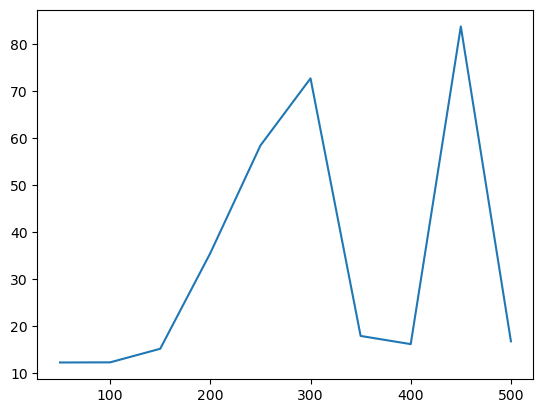

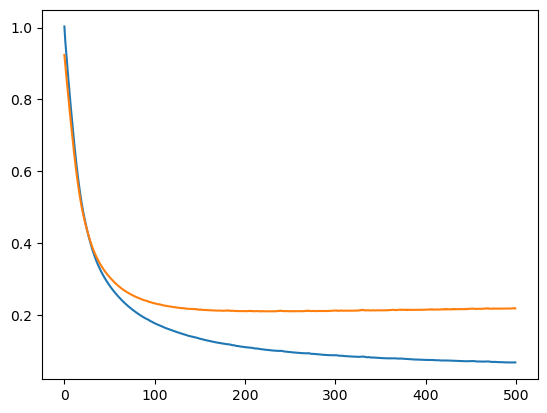

In [22]:
validation = np.array(val_loss)
plt.plot(validation[:, 0], np.log(validation[:, 1]))
plt.show()
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

In [23]:
model = SimpleNetwork()

checkpoint = torch.load("checkpoints/micro_nn/model_epoch_100.pt")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [24]:
x_test_tensor = torch.from_numpy(simple_x).float()
output = model(x_test_tensor).detach().numpy()

In [25]:
test_output = model(test_tensor).detach().numpy()
ntesty = test_y_tensor.detach().numpy()

In [26]:
error_matrix = (test_output - ntesty)
pro_error_matrix = ((test_output * 15 - 10) - (ntesty * 15 - 10))

print("Raw")
print(np.average(error_matrix ** 2))
print(np.average(np.abs(error_matrix)))

print("Processed")
print(np.average(pro_error_matrix ** 2))
print(np.average(np.abs(pro_error_matrix)))

Raw
0.23297913
0.34580022
Processed
52.420307
5.1870036


In [27]:
pair_loss = np.sum((simple_y - output) ** 2, axis=0)
print(pair_loss.shape)
get_notable(pair_loss)

(152,)


NameError: name 'get_notable' is not defined

In [28]:
pair_loss[63]

716.3925243452834

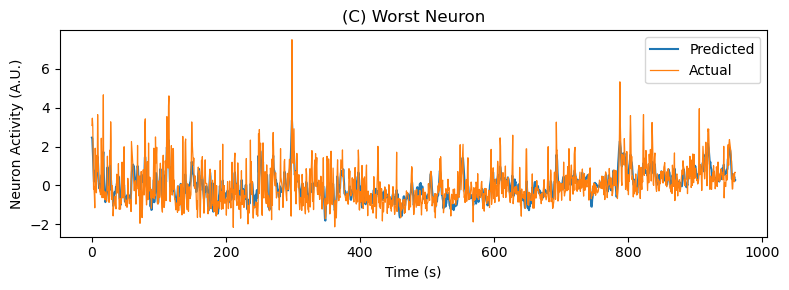

In [29]:


plt.title("(C) Worst Neuron")
plt.xlabel("Time (s)")
plt.ylabel("Neuron Activity (A.U.)")

fig = plt.gcf()
fig.set_size_inches(8, 3)
plt.tight_layout()

timecurve = np.linspace(0, 960, 1580)

plt.plot(timecurve, output[:, 63], label="Predicted")
plt.plot(timecurve, simple_y[:, 63], label="Actual", linewidth=0.9)

plt.legend(loc='best')
#plt.savefig('img/worst_xypair_simple_ann_n63.png', dpi=150)
plt.show()

In [30]:
output = model(test_tensor)

In [31]:
crit(test_y_tensor, output)

tensor(0.2330, grad_fn=<MseLossBackward0>)

In [32]:
# Far seeing / Close seeing

# Set window to 0 or -1 for different effect
window = simple_x[0]
window = window.reshape(1, 152, 20)

line = []

for i in range(1500):
    input = torch.from_numpy(window).float()
    out = model(input).detach().numpy().reshape(1, 152, 1)
    line.append(out)
    window = np.concatenate((window[:, :, 1:], out), axis=2) 

line = np.array(line).reshape(1500, 152)
ext_line = np.concatenate((simple_x[0].T, line), axis = 0).T
combined = np.concatenate((data.T, line), axis = 0).T
line = line.T

In [33]:
def get_notable(arr):
    # Create a list of tuples containing (element, index)
    indexed_arr = [(elem, idx) for idx, elem in enumerate(arr)]
    
    # Sort the indexed array based on element values
    sorted_arr = sorted(indexed_arr, key=lambda x: x[0])
    
    # Get the indices of the 5 lowest elements
    lowest_indices = [idx for _, idx in sorted_arr[:5]]
    
    # Get the indices of the 5 highest elements
    highest_indices = [idx for _, idx in sorted_arr[-5:]]
    
    return lowest_indices, highest_indices

In [34]:
error_matrix = (ext_line - data[:, :1520])
pro_error_matrix = ((ext_line * 15 - 10) - (data[:, :1520] * 15 - 10))

print("Raw")
print(np.average(error_matrix ** 2))
print(np.average(np.abs(error_matrix)))

print("Processed")
print(np.average(pro_error_matrix ** 2))
print(np.average(np.abs(pro_error_matrix)))

Raw
0.9180101782277156
0.7248046612763496
Processed
206.552290101236
10.872069919145245


In [35]:
loss = (ext_line[:,:500] - data[:,:500]) ** 2
loss_sums = np.sum(loss, axis=1)

In [38]:
0.010025914985390573 * 60

0.6015548991234344

In [36]:
get_notable(loss_sums)

([77, 70, 112, 114, 11], [122, 56, 86, 55, 117])

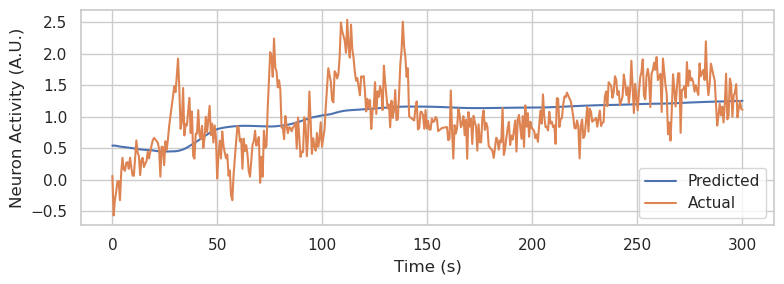

In [37]:
sns.set_theme(style="whitegrid")
timeline = np.linspace(0, 300.0, 500)

plt.plot(timeline, ext_line[77,1000:1500], label="Predicted")
plt.plot(timeline, data[77,1000:1500], label="Actual")

plt.legend(loc='best')

plt.xlabel("Time (s)")
plt.ylabel("Neuron Activity (A.U.)")

fig = plt.gcf()
fig.set_size_inches(8, 3)
plt.tight_layout()

#plt.savefig('img/third_worst_simple_ann_n126.png', dpi=150)
plt.show()